In [1]:
!pip install -q -r requirements.txt

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

from common.utils import is_notebook
from gridworld.gridworld import GridWorld
from gridworld.room_design import two_room_design as room_design
from stomp.framework import STOMP

In [3]:
num_runs = 100
all_runs = []

In [ ]:
progress_bar = (
    tqdm_notebook(range(num_runs)) if is_notebook() else tqdm(range(num_runs))
)

for run in progress_bar:
    env = GridWorld(room_design)
    stomp = STOMP(env)

    env.reset()
    option_learning_logs, options_model_learning_logs, planning_logs = stomp.learn(
        log_freq=None
    )
    all_runs.append((option_learning_logs, options_model_learning_logs, planning_logs))

    progress_bar.refresh()

In [ ]:
learning_options_start_state_estimative = []
planning_start_state_estimative = []
for run in all_runs:
    # Let's consider only the two rooms experiment
    # Therefore we have only one hallway
    learning_options_start_state_estimative.append(run[0][0])
    planning_start_state_estimative.append(run[2])
learning_options_start_state_estimative = np.stack(learning_options_start_state_estimative)
planning_start_state_estimative = np.stack(planning_start_state_estimative)
learning_options_start_state_estimative.shape, planning_start_state_estimative.shape

((100, 50000), (100, 6000))

In [50]:
learning_options_start_state_estimative_mean = np.mean(learning_options_start_state_estimative, axis=0)
learning_options_start_state_estimative_std = np.std(learning_options_start_state_estimative, axis=0)
learning_options_start_state_estimative_mean.shape, learning_options_start_state_estimative_std.shape

((50000,), (50000,))

In [51]:
planning_start_state_estimative_mean = np.mean(planning_start_state_estimative, axis=0)
planning_start_state_estimative_std = np.std(planning_start_state_estimative, axis=0)
planning_start_state_estimative_mean.shape, planning_start_state_estimative_std.shape

((6000,), (6000,))

In [57]:
def plot_arrays(mean_array, std_array, plotting_info):
    # Create figure and axis
    plt.figure(figsize=(20, 6))

    # Generate x-axis points (assuming these are sequential steps/episodes)
    x = np.arange(len(mean_array))

    # Plot mean line with shaded standard deviation
    plt.plot(x, mean_array, 'b-', label='Mean')
    plt.fill_between(x, 
                    mean_array - std_array,
                    mean_array + std_array,
                    color='b', alpha=0.2, label='Standard Deviation')

    # Customize the plot
    plt.xlabel(plotting_info["xlabel"])
    plt.ylabel(f'{plotting_info["ylabel"]}\n(Average Over 100 runs)')
    plt.title(plotting_info['title'])
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

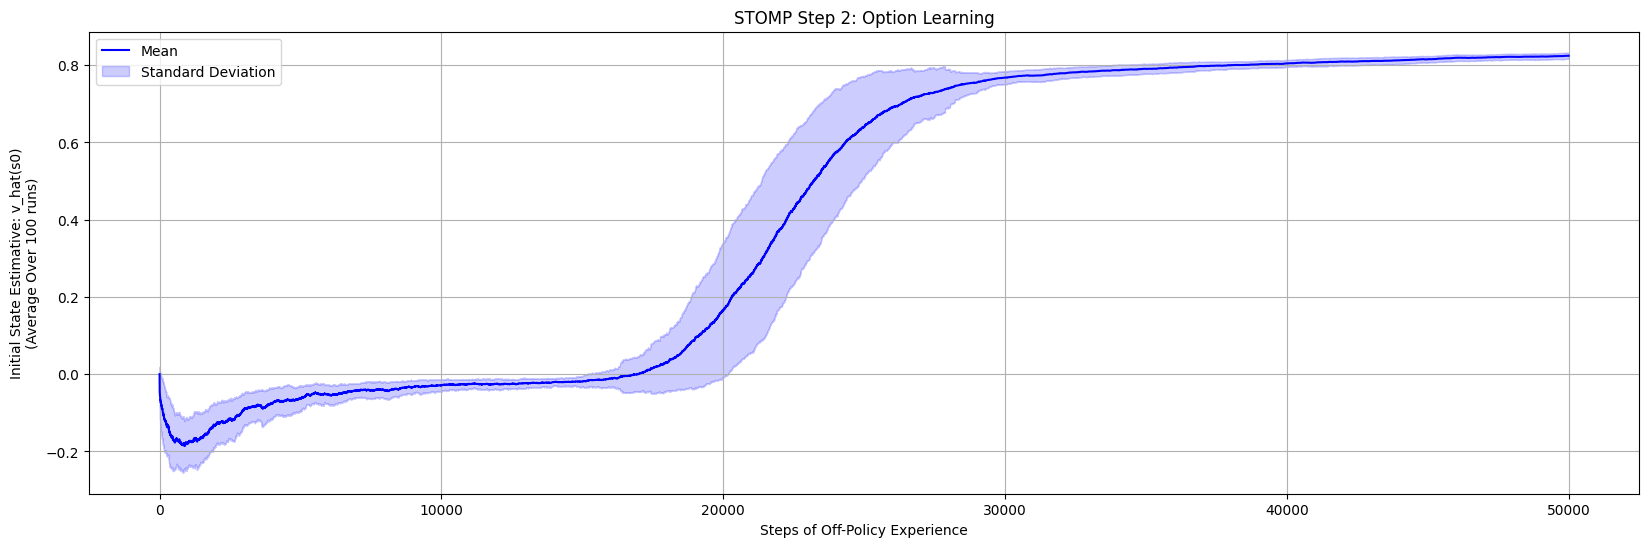

In [60]:
plot_arrays(
    learning_options_start_state_estimative_mean,
    learning_options_start_state_estimative_std,
    {
        "xlabel": "Steps of Off-Policy Experience",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 2: Option Learning"
    }
)

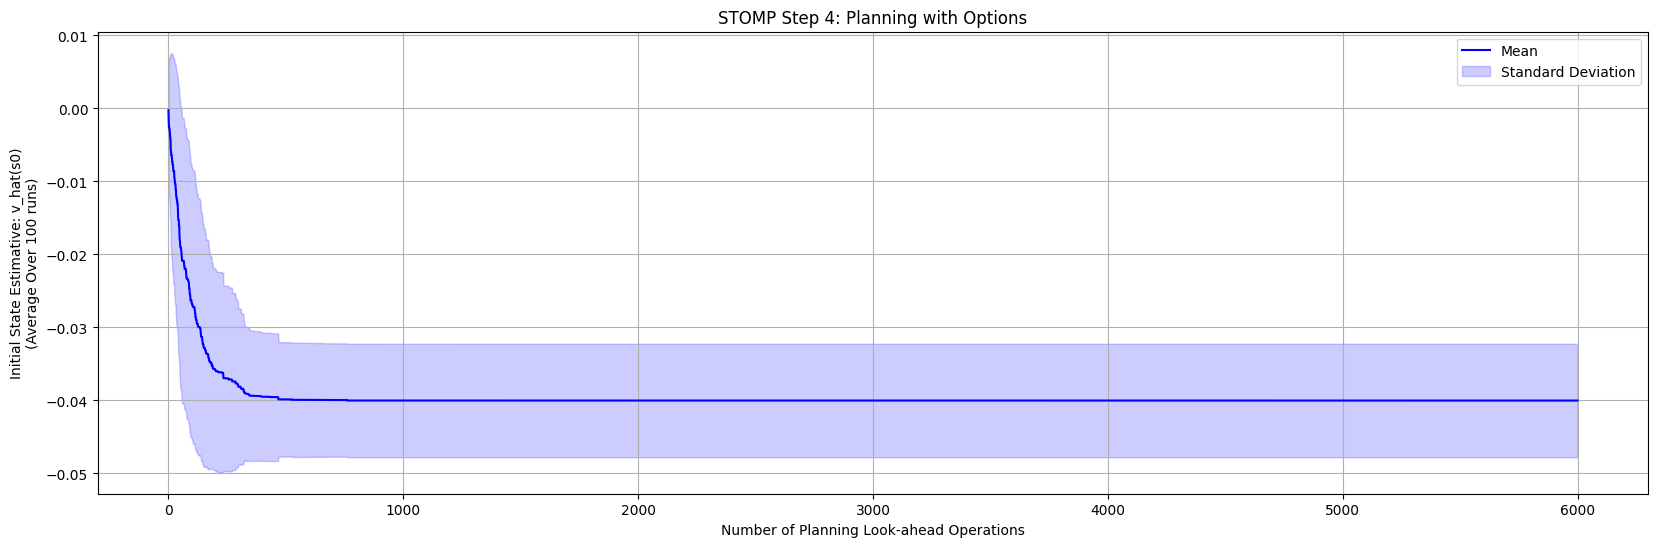

In [61]:
plot_arrays(
    planning_start_state_estimative_mean,
    planning_start_state_estimative_std,
    {
        "xlabel": "Number of Planning Look-ahead Operations",
        "ylabel": "Initial State Estimative: v_hat(s0)",
        "title": "STOMP Step 4: Planning with Options"
    }
)